In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import time
from typing import Tuple
import networkx as nx  # for plotting Graphs

from ba_graph import * 

### Disclaimer

In this script I am using word "node" as the translation for "wierzchołek", but later I realised it should be "vertex" (plur. "vertises"). Some sources claim that "node" have the same meaning, others don't. Albert-Laszlo Barabasi states in his [book](http://networksciencebook.com/chapter/2#networks-graphs) the proper naming convetion differences between Networking Science and Graph theory is:

Network science:
 - Network, 
 - Node, 
 - Link	                

Graph theory:
 - Graph, 
 - Vertex, 
 - Edge

#### Sorry for the confusing naming convention!

# Task 1 

Zadanie 1 Model rosnącego grafu scale-free: Barab ́asi-Albert (BA)

In [2]:
graph_sizes = [(100,3), (1000,3), (10000,2), (10000,3), (100000,3)]
print(graph_sizes[0][0], graph_sizes[0][1])

100 3


According to my collegues' suggestions the cut-off threshold for linear regression varies from 2 (n < 500) to 3. 

Spiral layout was selected as a form of my own education, as we can see the connections are very chaotic and do not fit well into a spiral form. 

Spring layout shows much more information in a visible form.

In [3]:
def build_BA_graph(size: Tuple[int, int], y_threshold=3):
    
    # n == size[0]
    # m == size[1]

    ba = BarabasiAlbertGraph(n=size[0], m=size[1], compute_connections=(size[0]<=1000))
    ba.build_graph()
    degrees = ba.get_degrees()

    x, y = np.unique(degrees, return_counts=True)
    plt.loglog(x, y, marker='.')

    #polyfit for linear regression:
    x_fit, y_fit = np.log10(x)[y > y_threshold], np.log10(y)[y > y_threshold]
    a, b = np.polyfit(x_fit, y_fit, 1)
    plt.plot([10 ** x_fit[0], 10 ** x_fit[-1]], [10 ** (x_fit[0] * a + b), 10 ** (x_fit[-1] * a + b)])

    plt.title(f'Degree distribution for n={size[0]}, m={size[1]}; a={a:0.3f}')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count (log)')
    plt.show()

    # Create Graph plots only for small ones:
    if size[0] <= 1000:
        G = nx.from_dict_of_lists(ba.connections) # create networkx graphs from lists of connections
        if size[0] <= 100:
            sizes = 10 + 30 * ba.get_degrees()
            width = 0.3
        else:
            sizes = 1 + 6 * ba.get_degrees()
            width = 0.1

        colors = ba.get_degrees() # Color varies from different degree

        plt.figure(figsize=(10, 10))
        nx.draw(G, pos=nx.spiral_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Spiral layout for n={size[0]}, m={size[1]}')
        plt.show()

        plt.figure(figsize=(10, 10))
        nx.draw(G, pos=nx.spring_layout(G), node_size=sizes, node_color=colors, width=width, cmap='plasma')
        plt.title(f'Spring layout for n={size[0]}, m={size[1]}')
        plt.show()


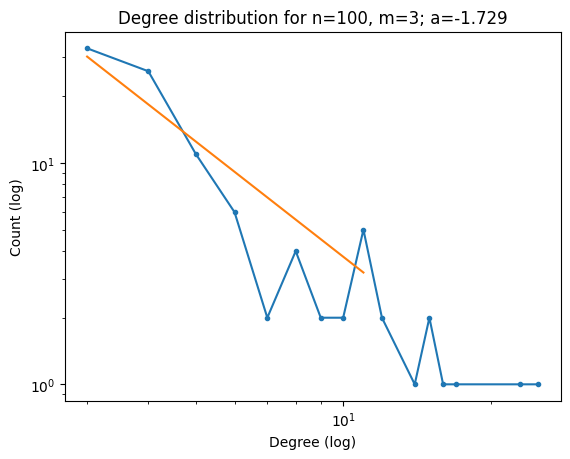

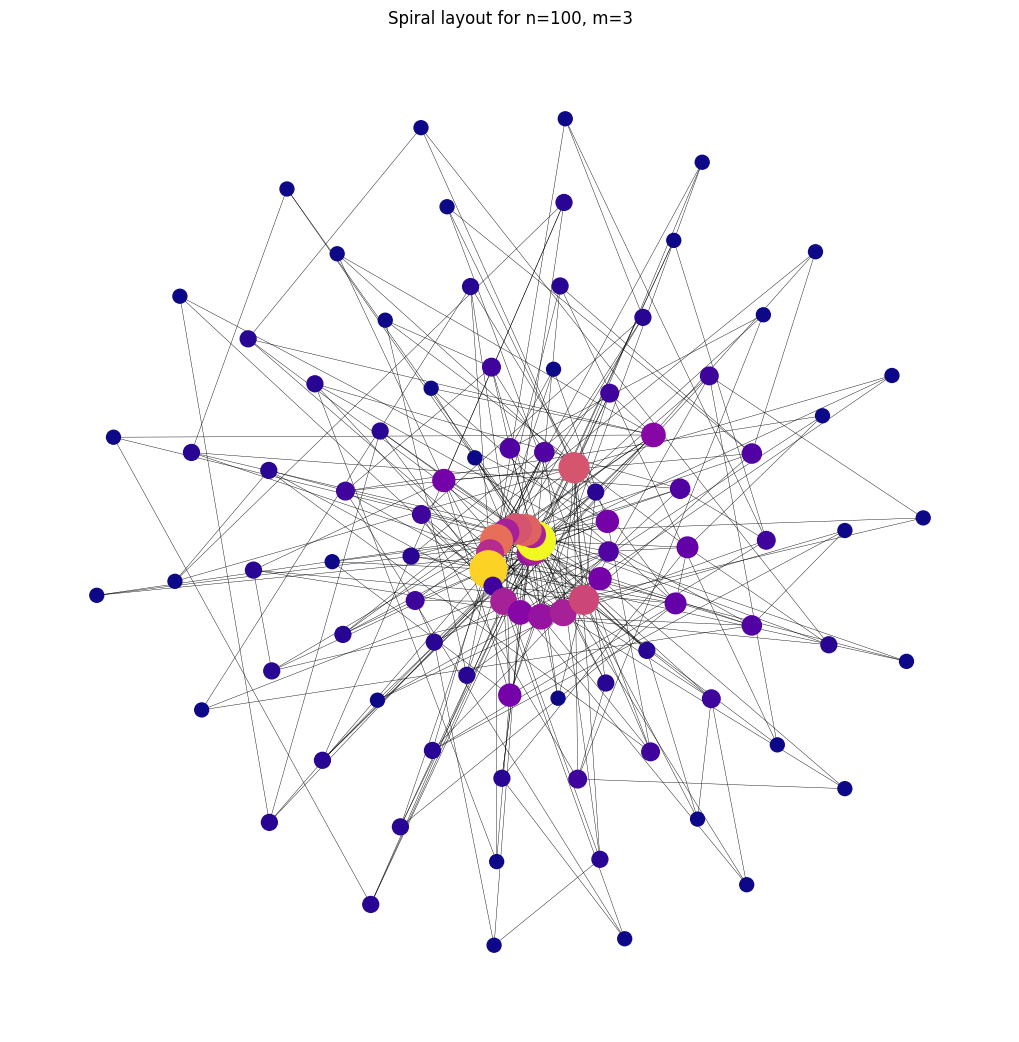

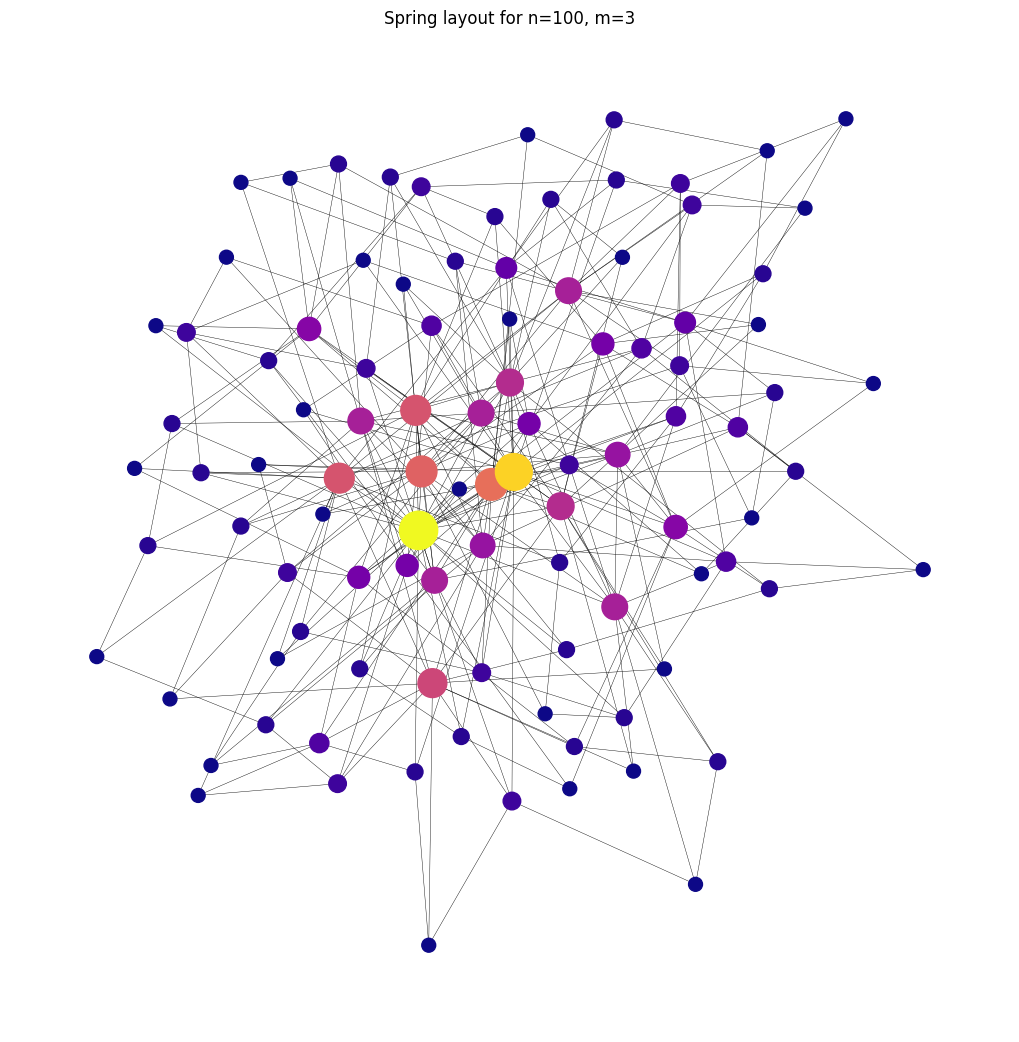

In [4]:
G0_size = graph_sizes[0]

build_BA_graph(G0_size, y_threshold=2)

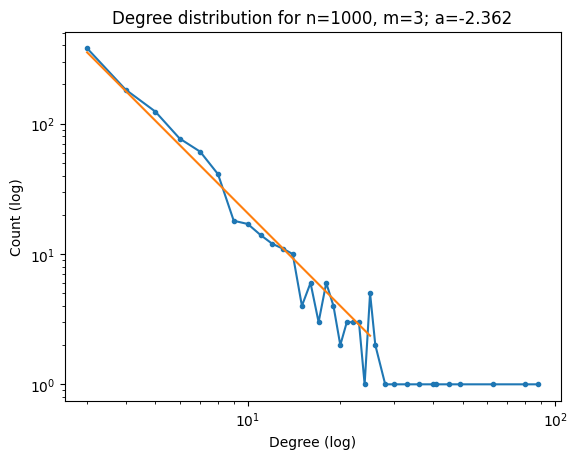

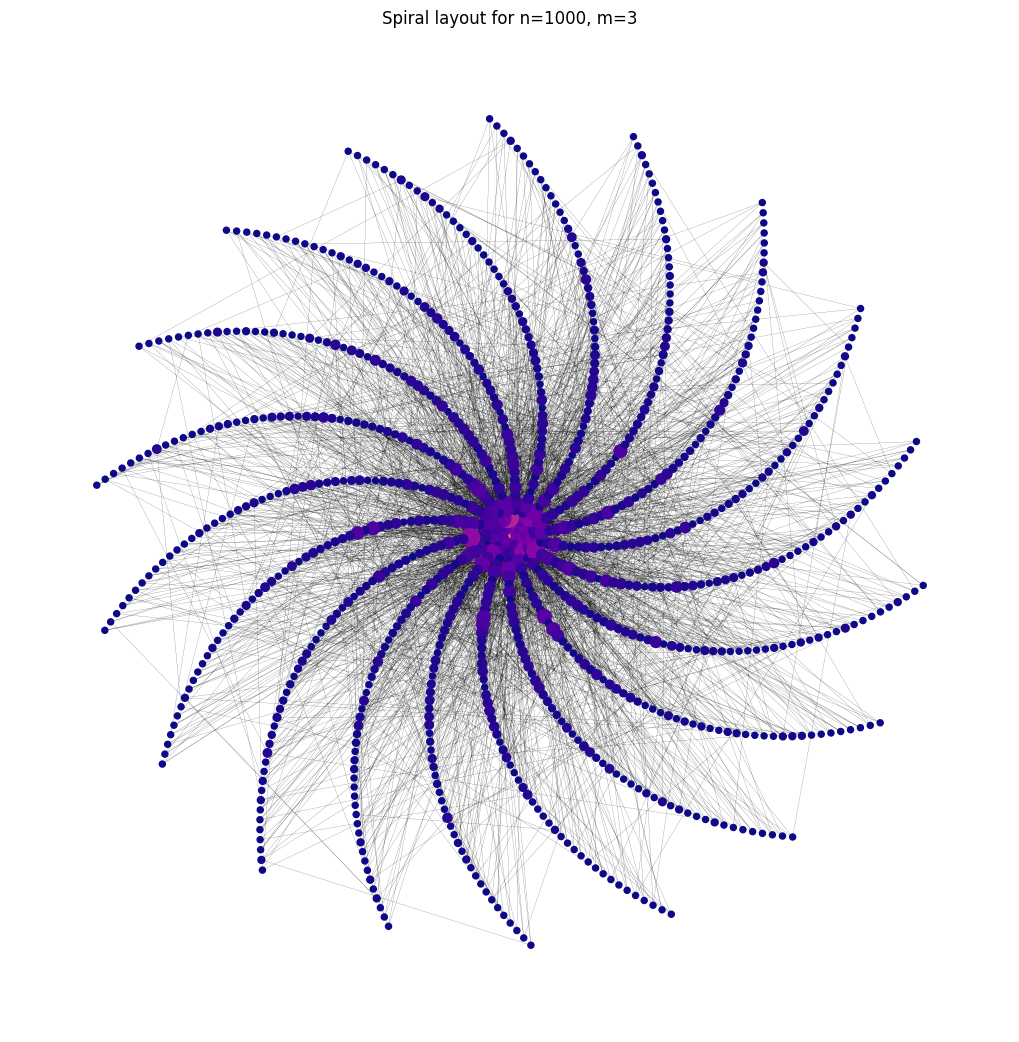

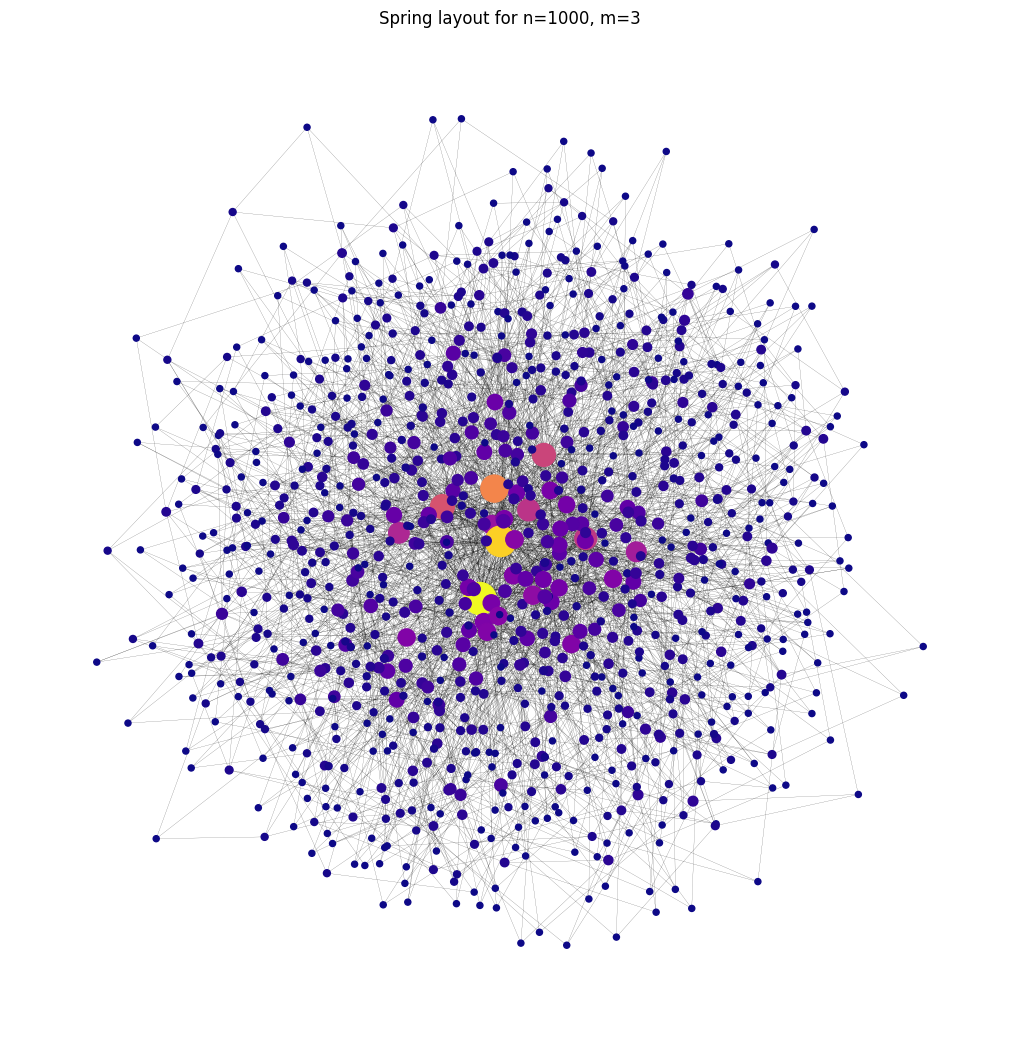

In [5]:
G1 = graph_sizes[1]

build_BA_graph(G1)

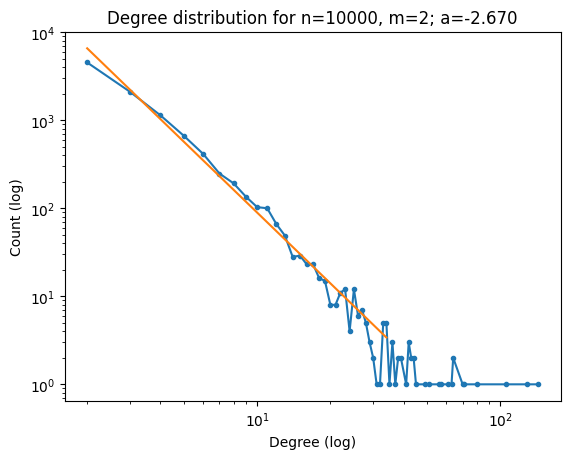

In [6]:
G2 = graph_sizes[2]

build_BA_graph(G2)

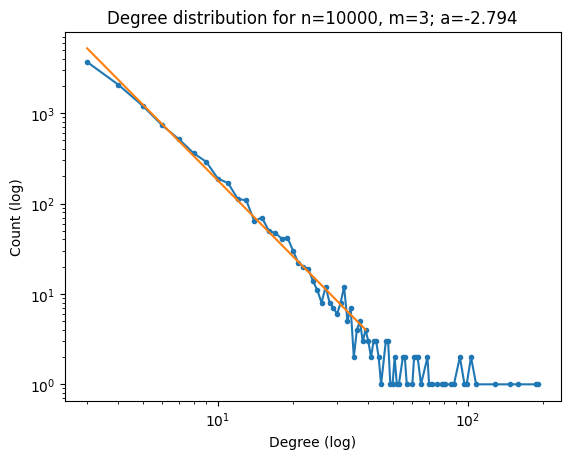

In [7]:
G3 = graph_sizes[3]
build_BA_graph(G3)

For n larger than 100000 the time is larger than 1 minute, stopped computing the 'a' at this level.

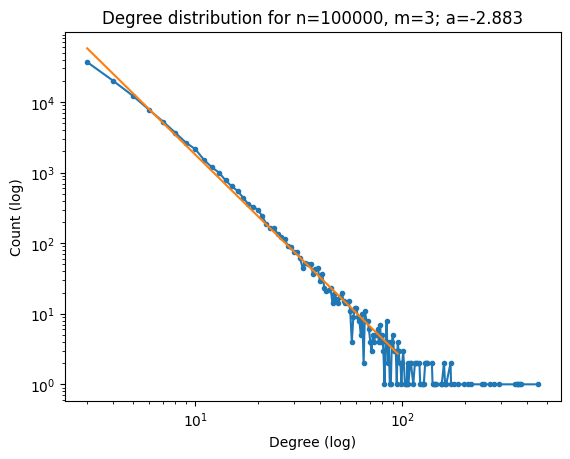

Elapsed time: 103.80308985710144


In [8]:
G4 = graph_sizes[4]
start = time.time()
build_BA_graph(G4)
stop = time.time()

print("Elapsed time:", stop-start)

The higher is the nodes count the closer the 'a' value is to -3.

# Task 2

Zadanie 2. Odporność grafu scale-free na błędy i ataki

In [9]:
graph_size = (100, 3)

In [10]:
def average_shortest_path_length(G: nx.classes.graph.Graph):
    d = dict(nx.shortest_path_length(G))
    n = len(d)
    return sum([sum(d_u.values()) for d_u in d.values()]) / (n * (n - 1))

def calculate_attack_stats(ba: BarabasiAlbertNodeRemover, n_size=graph_size[0]):
    f = []
    eff = []
    avg_len = []
    
    while ba.connections:
        f_this = (n_size - len(ba.connections)) / n_size * 100
        f.append(f_this)

        G = nx.from_dict_of_lists(ba.connections)
        eff.append(nx.global_efficiency(G))
        avg_len.append(average_shortest_path_length(G))

        ba.remove_node()
        
    return f, eff, avg_len

In [51]:
ba_rand = BarabasiAlbertNodeRemover(graph_size[0], graph_size[1], removal_mode='random')
ba_rand.build()
f_1, eff_1, avg_len_1 = calculate_attack_stats(ba_rand)

In [52]:
ba_atac = BarabasiAlbertNodeRemover(graph_size[0], graph_size[1], removal_mode='attack')
ba_atac.build()
f_2, eff_2, avg_len_2 = calculate_attack_stats(ba_atac)

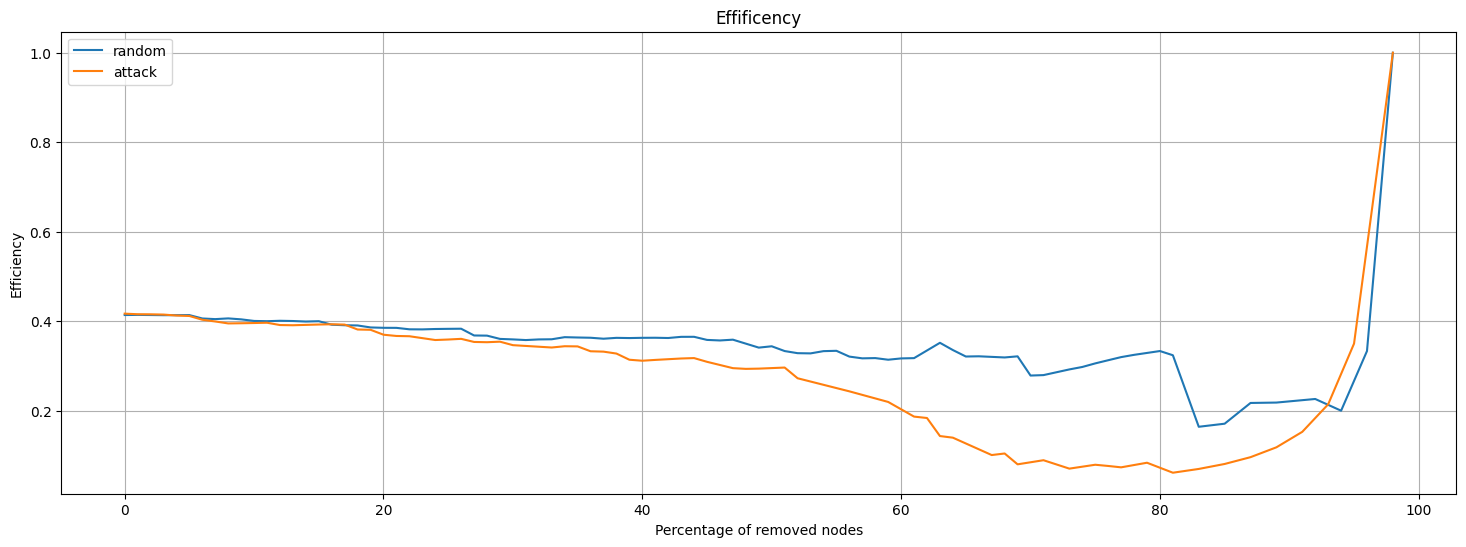

In [53]:
plt.figure(figsize=(18, 6))

plt.plot(f_1, eff_1, label='random')
plt.plot(f_2, eff_2, label='attack')
plt.grid()
plt.title('Effificency')
plt.xlabel('Percentage of removed nodes')
plt.ylabel('Efficiency')
plt.legend()

plt.show()


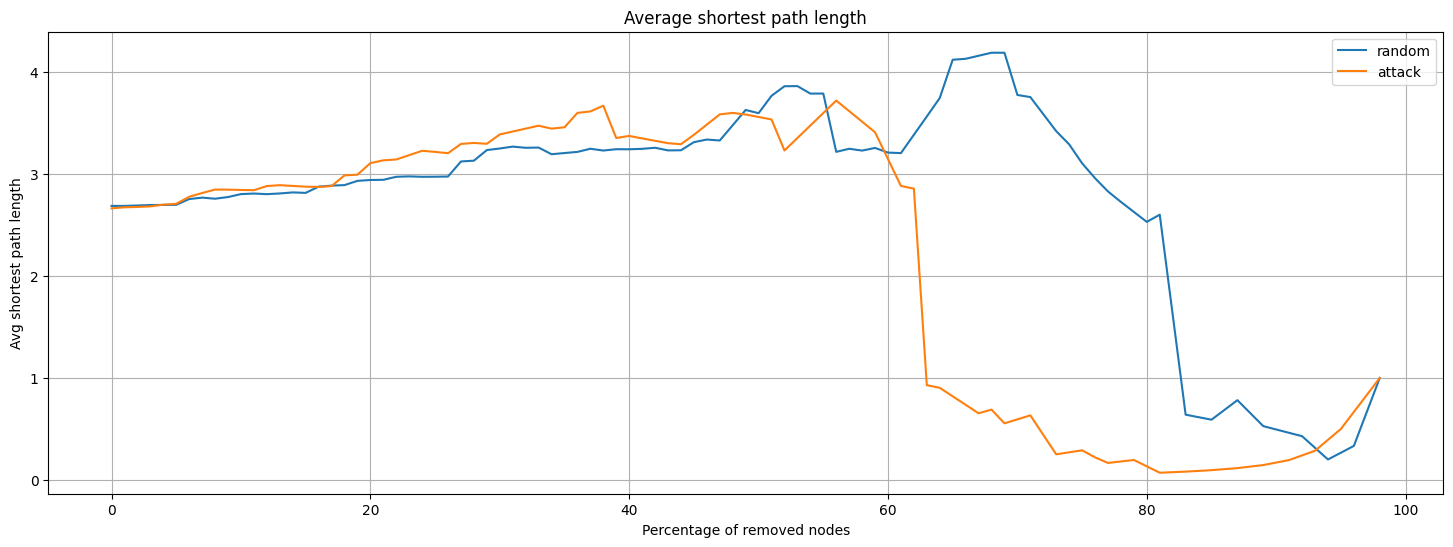

In [54]:
# 
plt.figure(figsize=(18, 6))

plt.plot(f_1, avg_len_1, label='random')
plt.plot(f_2, avg_len_2, label='attack')
plt.grid()
plt.title('Average shortest path length')
plt.xlabel('Percentage of removed nodes')
plt.ylabel('Avg shortest path length')
plt.legend()

plt.show()

As we can see after exceeding a certain percentage of removed nodes, the graph begins to divide into a lot of 'connected components', which makes calculating the distance meaningless. The 'cut_off' value was implemented, Be problem starts to be visible at around 60% of removed nodes.

In [55]:
def calculate_attack_stats_with_cut_off(ba: BarabasiAlbertNodeRemover, n_size=graph_size[0], cut_off=100):
    f = []
    eff = []
    avg_len = []
    
    while ba.connections:
        f_this = (n_size - len(ba.connections)) / n_size * 100
        if f_this > cut_off:  # cut-off at X percent
            break
        f.append(f_this)

        G = nx.from_dict_of_lists(ba.connections)
        eff.append(nx.global_efficiency(G))
        avg_len.append(average_shortest_path_length(G))

        ba.remove_node()
        
    return f, eff, avg_len

In [71]:
ba_rand = BarabasiAlbertNodeRemover(graph_size[0], graph_size[1], removal_mode='random')
ba_rand.build()
f_3, eff_3, avg_len_3 = calculate_attack_stats_with_cut_off(ba_rand, cut_off=60)

In [72]:
ba_atac = BarabasiAlbertNodeRemover(graph_size[0], graph_size[1], removal_mode='attack')
ba_atac.build()
f_4, eff_4, avg_len_4 = calculate_attack_stats_with_cut_off(ba_atac, cut_off=60)

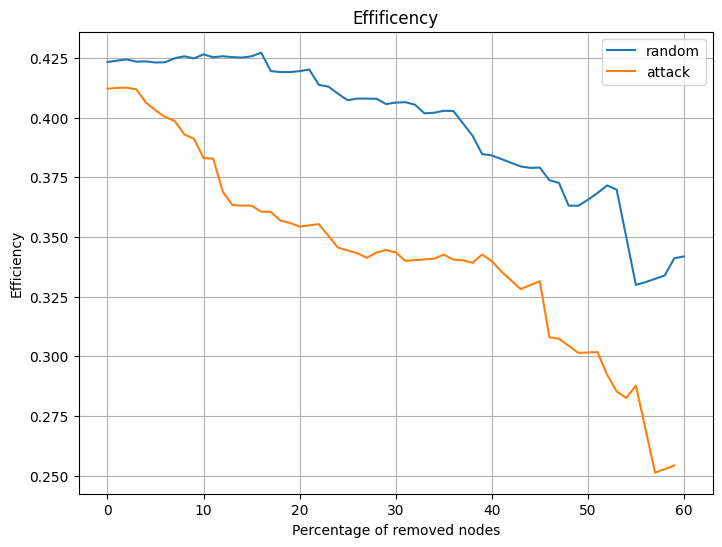

In [73]:
plt.figure(figsize=(18, 6))
    
plt.subplot(1, 2, 1)
plt.plot(f_3, eff_3, label='random')
plt.plot(f_4, eff_4, label='attack')
plt.grid()
plt.title('Effificency')
plt.xlabel('Percentage of removed nodes')
plt.ylabel('Efficiency')
plt.legend()

plt.show()

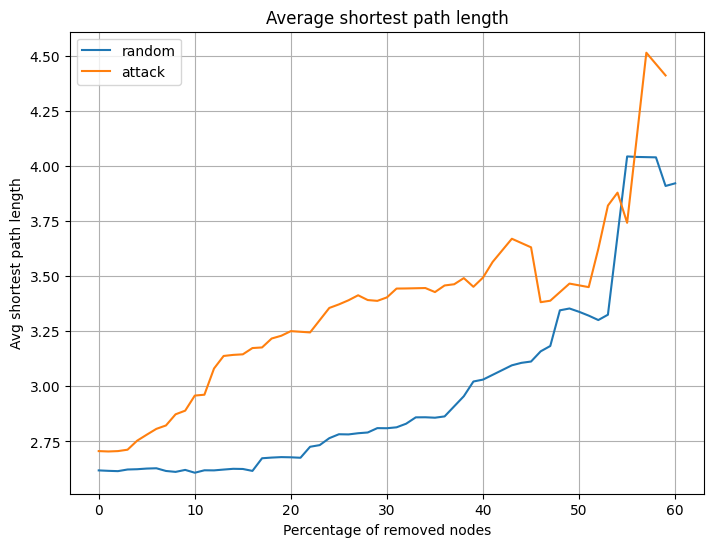

In [74]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 2)
plt.plot(f_3, avg_len_3, label='random')
plt.plot(f_4, avg_len_4, label='attack')
plt.grid()
plt.title('Average shortest path length')
plt.xlabel('Percentage of removed nodes')
plt.ylabel('Avg shortest path length')
plt.legend()

plt.show()

## Observations:

 - Removing nodes randomly has a slightly less severe effect on the Efficiency than a deliberate attack with proportional probability.
 - Removing nodes with a high number of connections causes a higher increase of average shortest path lenght. 
 - At 60% of removed nodes the efficiency is around 50% of pre-attack removal, random removal method has only about 20% drop of efficiency. 
 - At 60# of removed nodes with the Attack method the average shortest path is around 10% longer than with random removal.


## Knowledge source and inspiration:

As a main source of inspiration for this source is Barabasi-Alber Network Model by Aleksander Molak: https://github.com/AlxndrMlk/Barabasi-Albert_Network/blob/master/BA_model.ipynb

